# Практическая работа №6

### __Задание 1:__ Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

from sklearn.datasets import load_diabetes

import matplotlib.pyplot as plt

import random

In [2]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

In [3]:
y.mean()

152.13348416289594

In [4]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])
    

In [5]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

In [6]:
def bias(y, z):
    return (y - z)

In [7]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, batch_rate=1.0):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # будем обучать модель не на полной выборке, а только на части  случайных объектов
        idx = np.array([ False for _ in range(X_train.shape[0])])
        idx_indexes = list(range(0, idx.shape[0]))
        random.shuffle(idx_indexes)
        idx_indexes = np.resize(idx_indexes, int(len(idx_indexes)*batch_rate))
        idx[idx_indexes]= True

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train[idx], y_train[idx])
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train[idx], bias(y_train[idx], target[idx]))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

In [8]:
def get_error_plot(n_trees, train_err, test_err, x_label='Iteration number', label1_name='train error', label2_name='test error'):
    plt.xlabel(x_label)
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label=label1_name)
    plt.plot(list(range(n_trees)), test_err, label=label2_name)
    plt.legend(loc='upper right')
    plt.show()

In [9]:
# Число деревьев в ансамбле
n_trees = 100

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Шаг
eta = 0.05

# Максимальная глубина деревьев
max_depth = 3

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

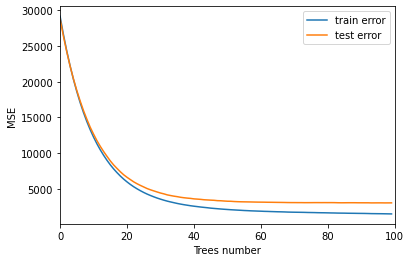

In [10]:
get_error_plot(n_trees, train_errors, test_errors, x_label='Trees number')

При шаге обучения 0.05 алгоритм сходится в районе 30 деревьев 

Посчитаем ошибку при разной глубине деревьев

In [11]:
n_trees = 30

n_depth = 10
train_err = []
test_err = []
for depth in range(1, n_depth+1):
    trees, train_errors, test_errors = gb_fit(n_trees, depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_err.append(train_errors[-1])
    test_err.append(test_errors[-1])

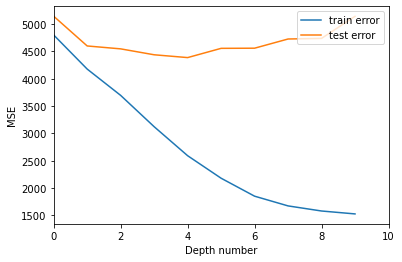

In [12]:
get_error_plot(n_depth, train_err, test_err, x_label='Depth number')

In [13]:
# Число деревьев в ансамбле
n_trees = 30

# Максимальная глубина деревьев
max_depth = 5

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

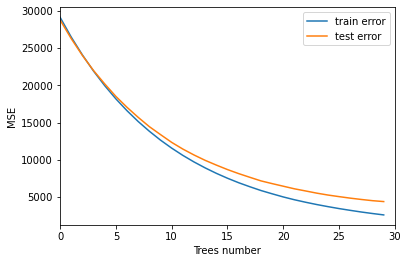

In [14]:
get_error_plot(n_trees, train_errors, test_errors, x_label='Trees number')

При увеличении максимальной глубины до 7 алгоритм сходится на 15-20 деревьях, но ошибка возрастает с 3.5 до 5 тысяч.

## __Задание 2: (опция) .__ Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

In [16]:
# Число деревьев в ансамбле
n_trees = 40

# Максимальная глубина деревьев
max_depth = 7

trees1, train_errors1, test_errors1 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
trees2, train_errors2, test_errors2 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta, batch_rate=0.5)

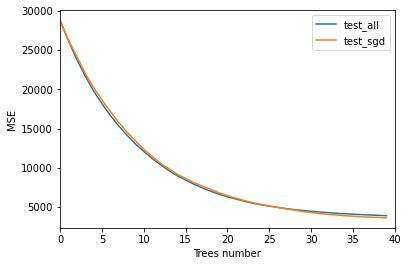

In [17]:
get_error_plot(n_trees, test_errors1, test_errors2, x_label='Trees number', label1_name='test_all', label2_name='test_sgd')

У стахостического метода ошибка оказалась меньше

## __Задание 3:(опция).__ Реализовать алгоритм градиетного бустинга, основанный на реализации решающего дерева из ДЗ4 / методички к уроку 4. Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

In [18]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [19]:
# Реализуем класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        return  self.labels.mean()
    
    def classify_object(self, obj):
        return self

In [20]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
    
    def classify_object(self, obj):
        if obj[self.index] <= self.t:
          return self.true_branch.classify_object(obj)
        else:
          return self.false_branch.classify_object(obj)
        

In [21]:
# Расчет критерия информативности

def variance(labels):
    v = labels.var()
    return v      

In [22]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [23]:
def get_subsample(len_sample, len_subsample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    subsample = []
    random.shuffle(sample_indexes)
    for _ in range(min(len_sample, len_subsample)):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [24]:
# Реализуем класс дерева

class Tree:

    def __init__(self, min_leaf=5, criteria_call=variance, max_level=1000, max_features=1000000):
        self.root = None
        self.min_leaf = min_leaf # минимальное количество объектов в узле
        self.criteria_call = criteria_call #функция расчета критерия информативности
        self.max_level = max_level #максимальная глубина дерева
        self.max_features = max_features #максимальное количество обрабатываемых признаков 

    def set_min_leaf(self, min_leaf):
        self.min_leaf = min_leaf
        return self 
    
    def set_criteria_call(self, criteria_call):
        self.criteria_call = criteria_call
        return self

    def set_max_level(self, max_level):
        self.max_level = max_level
        return self
    
    def set_max_features(self, max_features):
        self.max_features = max_features
        return self

    def classify_object(self, obj):
        return self.root.classify_object(obj)

    def predict(self, data):
        classes = []
        for obj in data:
            leaf_ = self.classify_object(obj)
            classes.append(leaf_.prediction)
        return classes

    def in_leaf(self, data):
        classes = []
        for obj in data:
            leaf_ = self.classify_object(obj)
            classes.append(obj in leaf_.data)
        return classes

    def build(self, data, labels):
        self.root = self.build_tree(data, labels)
        return self
    
    def build_tree(self, data, labels, level=0):

        quality, t, index = self.find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if (quality == 0) | (level >= self.max_level):
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, level=level+1)
        false_branch = self.build_tree(false_data, false_labels, level=level+1)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
    
    def find_best_split(self, data, labels):
        current_criteria = self.criteria_call(labels)

        best_quality = 0
        best_t = None
        best_index = None
    
        n_features = data.shape[1]

        # выбор индекса из подвыборки длиной sqrt(n_features)
        subsample = get_subsample(n_features, self.max_features)

        for index in subsample:
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])
        
            for t in t_values:
                true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue
            
                current_quality = self.quality(true_labels, false_labels, current_criteria)
            
                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                  best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def quality(self, left_labels, right_labels, current_criteria):
        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
        return current_criteria - p * self.criteria_call(left_labels) - (1 - p) * self.criteria_call(right_labels)

In [25]:
# Реализуем класс лес

class GB_Forest:

    def __init__(self, n_trees, coefs, eta=0.1, batch_rate=1.0, min_leaf=5, criteria_call=variance, max_level=1000, max_features=1000000):  
        self.n_trees = n_trees
        self.forest = []
        self.min_leaf = min_leaf # минимальное количество объектов в узле
        self.criteria_call = criteria_call #функция расчета критерия информативности
        self.max_level = max_level #максимальная глубина дерева
        self.max_features = max_features #максимальное количество обрабатываемых признаков 
        self.coefs = coefs.copy()
        self.eta = eta
        self.batch_rate = batch_rate

    def set_min_leaf(self, min_leaf):
        self.min_leaf = min_leaf
        return self 
    
    def set_criteria_call(self, criteria_call):
        self.criteria_call = criteria_call
        return self

    def set_max_level(self, max_level):
        self.max_level = max_level
        return self
    
    def set_max_features(self, max_features):
        self.max_features = max_features
        return self
    
    def mean_squared_error(self, y_real, prediction):
        return (sum((y_real - prediction)**2)) / len(y_real)
    
    def bias(self, y, z):
        return (y - z)

    def build(self,  X_train, X_test, y_train, y_test):
    
        # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
        train_errors = []
        test_errors = []
    
        for i in range(self.n_trees):
            #tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
            tree = Tree(min_leaf=self.min_leaf, criteria_call=self.criteria_call, max_level=self.max_level, max_features=self.max_features)

            # будем обучать модель не на полной выборке, а только на части  случайных объектов
            idx = np.array([ False for _ in range(X_train.shape[0])])
            idx_indexes = list(range(0, idx.shape[0]))
            random.shuffle(idx_indexes)
            idx_indexes = np.resize(idx_indexes, int(len(idx_indexes)*self.batch_rate))
            idx[idx_indexes]= True

            # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
            # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
            if len(self.forest) == 0:
                # обучаем первое дерево на обучающей выборке
                tree.build(X_train[idx], y_train[idx])
            
                train_errors.append(self.mean_squared_error(y_train, self.predict(X_train)))
                test_errors.append(self.mean_squared_error(y_test, self.predict(X_test)))
            else:
                # Получим ответы на текущей композиции
                target = self.predict(X_train)
            
                # алгоритмы начиная со второго обучаем на сдвиг
                tree.build(X_train[idx], self.bias(y_train[idx], target[idx]))
            
                train_errors.append(self.mean_squared_error(y_train, self.predict(X_train)))
                test_errors.append(self.mean_squared_error(y_test, self.predict(X_test)))

            self.forest.append(tree)
        
        return train_errors, test_errors

    def predict(self, X):
        # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
        # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
        return np.array([sum([self.eta* coef * tree.predict([x])[0] for tree, coef in zip(self.forest, self.coefs)]) for x in X])
    
    def oob(self, data, labels):

        # добавим используемость всех деревьев в список
        predictions = []
        in_trees = []
        for tree in self.forest:
            predictions.append(tree.predict(data))
            in_trees.append(tree.in_leaf(data))

        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))
        # сформируем список с используемостью для каждого объекта
        in_trees_per_object = list(zip(*in_trees))

        # Для каждого объекта посчитаем ошибку на тех деревьях
        # в обучении которых объект не принимал участие (его нет в листьях)
        err = 0
        for i, obj in enumerate(predictions_per_object):
            err_obj = 0
            n_obj = 0
            for j, predict in enumerate(obj):
                if in_trees_per_object[i][j] == False:
                    err_obj += np.abs(labels[i] - predict)
                    n_obj += 1
            if n_obj > 0:
                err += err_obj / n_obj
        
        return err


In [26]:
# Число деревьев в ансамбле
n_trees = 40

# для простоты примем коэффициенты равными 1
coefs = [1] * n_trees

# Шаг
eta = 0.05

# Максимальная глубина деревьев
max_depth = 5

forest = GB_Forest(n_trees=n_trees, min_leaf=5, max_level=max_depth, eta=eta, coefs=coefs)
train_errors2, test_errors2 = forest.build( X_train, X_test, y_train, y_test)


trees1, train_errors1, test_errors1 = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)

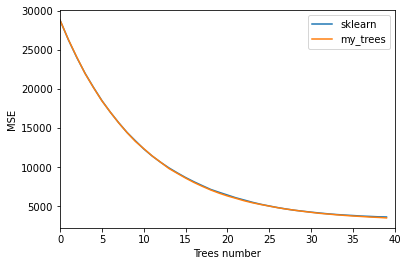

In [27]:
get_error_plot(n_trees, test_errors1, test_errors2, x_label='Trees number', label1_name='sklearn', label2_name='my_trees')

Разницы нет, программа из sklearn дает такую же ошибку как и ансамбль решающих деревьев из ДЗ4